In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image

# retrieve the images paths (color and leftimg8bit)

In [2]:
def extract_cityscape_label_img_paths(path):

    cityscape_lbl_img_paths = []
    for root, dirs, files in os.walk(path):
        if "\\" in root:
            #print(root)
            for file in files:
                if "color" in file:
                    cityscape_lbl_img_paths.append(os.path.join(root, file))

    return cityscape_lbl_img_paths

gtfine_train_path = extract_cityscape_label_img_paths('C://Users/Admin/Desktop/000-data_science/sem2-project_1/images/cityscape_img/gtFine/train')
gtfine_valid_path = extract_cityscape_label_img_paths('C://Users/Admin/Desktop/000-data_science/sem2-project_1/images/cityscape_img/gtFine/val')

In [3]:
def get_leftimg(path):
    leftimg_files = []
    for root, dirs, files in os.walk(path):
        #print(root)
        for file in files:
            leftimg_files.append(os.path.join(root, file))

    return leftimg_files

leftimg_train_file_paths = get_leftimg("C://Users/Admin/Desktop/000-data_science/sem2-project_1/images/cityscape_img/leftImg8bit/train")
leftimg_val_file_paths = get_leftimg("C://Users/Admin/Desktop/000-data_science/sem2-project_1/images/cityscape_img/leftImg8bit/val")

In [4]:
# train pair
cityscape_train_img_lbl_pair = []
for lbl, img in zip(sorted(gtfine_train_path), sorted(leftimg_train_file_paths)):
    cityscape_train_img_lbl_pair.append([img, lbl])

cityscape_train_img_lbl_pair[0][1]

'C://Users/Admin/Desktop/000-data_science/sem2-project_1/images/cityscape_img/gtFine/train\\aachen\\aachen_000000_000019_gtFine_color.png'

In [5]:
# validation pair
cityscape_val_img_lbl_pair = []
for lbl, img in zip(sorted(gtfine_valid_path), sorted(leftimg_val_file_paths)):
    cityscape_val_img_lbl_pair.append([img, lbl])

cityscape_val_img_lbl_pair[0]

['C://Users/Admin/Desktop/000-data_science/sem2-project_1/images/cityscape_img/leftImg8bit/val\\frankfurt\\frankfurt_000000_000294_leftImg8bit.png',
 'C://Users/Admin/Desktop/000-data_science/sem2-project_1/images/cityscape_img/gtFine/val\\frankfurt\\frankfurt_000000_000294_gtFine_color.png']

# Load to array

In [6]:
def reformat_and_load_arr(path_list, raw_or_lbl):
    """
    from path list, load all images and resize and convert to jpg. Then load into a list of arrays.
    """
    img_list = []
    for i, img_path in enumerate(path_list):
        img_arr = np.asarray(Image.open(img_path[raw_or_lbl]))[:, :, :3]   # resize will change the 
        img_list.append(img_arr.copy())  

    return img_list



In [7]:
# reformat and load train data into list of array
train_img_lbl = reformat_and_load_arr(cityscape_train_img_lbl_pair, 1)
train_img_raw = reformat_and_load_arr(cityscape_train_img_lbl_pair, 0)

In [8]:
# reformat and load valid image data into list of array
val_img_lbl = reformat_and_load_arr(cityscape_val_img_lbl_pair, 1)
val_img_raw = reformat_and_load_arr(cityscape_val_img_lbl_pair, 0)

In [9]:
len(val_img_lbl)

500

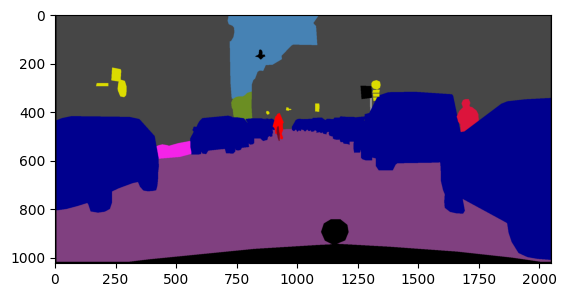

In [10]:
import matplotlib.pyplot as plt
plt.imshow(train_img_lbl[1150])

In [18]:
def save_as_npz(file_path, list_of_array):
    # Convert the list of arrays to a dictionary
    arrays_dict = {f'array_{i}': arr for i, arr in enumerate(list_of_array)}

    # Save the dictionary of arrays using np.savez
    np.savez(file_path, **arrays_dict)

In [12]:
save_as_npz('cityscape_train_raw.npz', train_img_raw)
save_as_npz('cityscape_train_lbl_unprocessed.npz', train_img_lbl)

In [13]:
save_as_npz('cityscape_val_raw.npz', val_img_raw)
save_as_npz('cityscape_val_lbl_unprocessed.npz', val_img_lbl)

# change label to green / non-green binary mask

In [20]:
cityscape_train_lbl = np.load('cityscape_train_lbl_unprocessed.npz')
cityscape_train_raw = np.load('cityscape_train_raw.npz')

cityscape_val_lbl = np.load('cityscape_val_lbl_unprocessed.npz')
cityscape_val_raw = np.load('cityscape_val_raw.npz')

In [4]:
# get unique colors for vegetation and terrain (nature)
image_2d = cityscape_val_lbl['array_0'].reshape(-1, 3)
#image_2d = val_img_lbl[0].reshape(-1, 4)

# Reshape the image to a 2D array
#image_2d = image.reshape(-1, 4)

# Get the unique color combinations
unique_colors = np.unique(image_2d, axis=0)

# Print the unique colors
for color in unique_colors:
    print(color)

[0 0 0]
[  0   0 142]
[70 70 70]
[ 70 130 180]
[107 142  35]
[128  64 128]
[153 153 153]
[190 153 153]
[220  20  60]
[220 220   0]
[244  35 232]


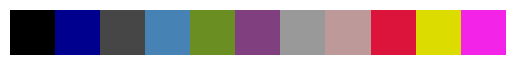

In [16]:
import matplotlib.pyplot as plt

# Create an image with the unique colors
color_image = np.zeros((1, len(unique_colors), 3), dtype=np.uint8)
color_image[0] = unique_colors

# Display the unique colors
plt.imshow(color_image)
plt.axis('off')
plt.show()

In [10]:
def get_bw_lbl(npz_file):
    # Define the target channel values and the new values
    target_values = [[107, 142, 35], [152, 251, 152]]
    new_value = [255, 255, 255]
    other_value = [0, 0, 0]

    bw_lbl = []
    for file in npz_file.files:
        image = npz_file[file] 

        # Create a Boolean mask for the target values
        mask = np.logical_or.reduce([np.all(image == value, axis=2) for value in target_values])   # logical_or.reduce is to combine list of 2 arrays in a single array

        # Set the pixels with the target values to the new value
        image[mask] = new_value

        # Set the other pixels to the other value
        image[~mask] = other_value

        bw_lbl.append(image)

    return bw_lbl

In [11]:
train_lbl_bw= get_bw_lbl(cityscape_train_lbl)

In [14]:
save_as_npz('cityscape_train_lbl_bw.npz', train_lbl_bw)

In [15]:
val_lbl_bw = get_bw_lbl(cityscape_val_lbl)
save_as_npz('cityscape_val_lbl_bw.npz', val_lbl_bw)

In [1]:
# make into 1 channel
import numpy as np

def change_to_1channel(npz_file):
    x = np.load(npz_file)
    lbl_1chan = []
    for file in x.files:
        lbl_1chan.append(x[file][:, :, 0])

    return lbl_1chan

train_lbl_1chan = change_to_1channel('cityscape_train_lbl_bw.npz')
val_lbl_1chan = change_to_1channel('cityscape_val_lbl_bw.npz')

In [3]:
from PIL import Image
np.asarray(Image.fromarray(val_lbl_1chan[0]).resize((1024, 512))).shape

(512, 1024)

In [12]:
from PIL import Image

def rescale_and_clip_img(list_of_array):
    list_of_arrays = list_of_array.copy()
    
    for i, arr in enumerate(list_of_arrays):
        x = np.asarray(Image.fromarray(arr).resize((1024, 512))).copy()
        x[x < 100] = 0
        x[x >= 100] = 1

        left_clip = np.random.randint(0, 512)
        list_of_arrays[i] = x[:, left_clip : left_clip + 512 ]

    return list_of_arrays

final_train_lbl = rescale_and_clip_img(train_lbl_1chan)
final_val_lbl = rescale_and_clip_img(val_lbl_1chan)

In [19]:
save_as_npz('cityscape_train_lbl_final.npz', final_train_lbl)
save_as_npz('cityscape_tval_lbl_final.npz', final_val_lbl)

In [24]:
cityscape_train_raw = np.load('cityscape_train_raw.npz')
cityscape_val_raw = np.load('cityscape_val_raw.npz')

def rescale_img_raw(npz_file):

    final_raw_img = []
    for file in npz_file.files:
        x = np.asarray(Image.fromarray(npz_file[file]).resize((1024, 512))).copy()
        left_clip = np.random.randint(0, 512)
        final_raw_img.append(x[:, left_clip : left_clip + 512 ])

    return final_raw_img

In [25]:
final_train_raw = rescale_img_raw(cityscape_train_raw)
final_val_raw = rescale_img_raw(cityscape_val_raw)

In [30]:
save_as_npz('cityscape_train_raw_final.npz', final_train_raw)
save_as_npz('cityscape_val_raw_final.npz', final_val_raw)

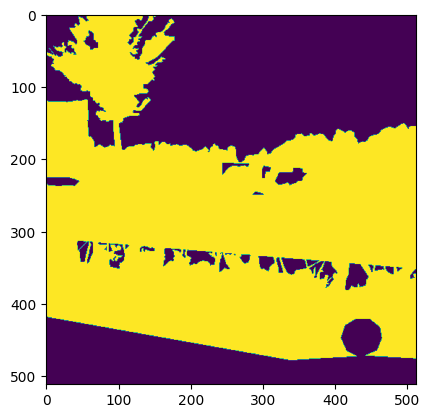

In [29]:
import matplotlib.pyplot as plt

plt.imshow(final_train_lbl[152])

In [97]:
for i in range(len(bw_lbl_1chan)):
    left_clip = np.random.randint(0, 512)
    bw_lbl_1chan[i] = bw_lbl_1chan[i][:, left_clip : left_clip + 512 ]

In [101]:
# Convert the list of arrays to a dictionary
arrays_dict = {f'array_{i}': arr for i, arr in enumerate(bw_lbl_1chan)}

# Save the dictionary of arrays using np.savez
np.savez('cityscape_train_lbl.npz', **arrays_dict)

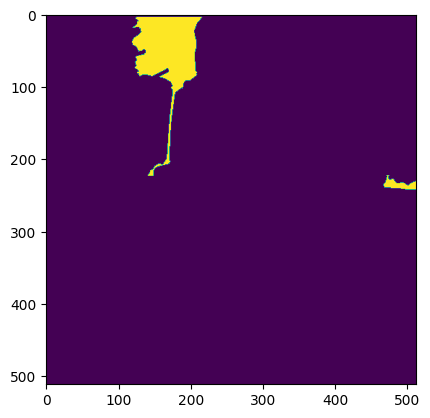

In [98]:
plt.imshow(bw_lbl_1chan[35])

# clip images to form images of appropriate shape for HRNet-OCR

In [67]:
import tensorflow as tf

model = tf.keras.models.load_model("treepedia_dl_public-master/weights_test.hdf5")

In [ ]:
# Create a new input layer
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))

# Connect the input layer to the pretrained model's layers
output = pretrained_model(input_layer)

# Create the new model with the input layer and pretrained model's layers
model = tf.keras.Model(inputs=input_layer, outputs=output)

# Print the model summary
model.summary()

In [72]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

new_input = Input(shape=(224, 224, 3))
#first_layer = model.layers[0](new_input)
output = model(new_input) # Get the last layer of the existing model
new_model = Model(inputs=new_input, outputs=output)


In [73]:
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 1)                 26090601  
                                                                 
Total params: 26,090,601
Trainable params: 26,037,481
Non-trainable params: 53,120
_________________________________________________________________


In [75]:
model = torch.load("C://Users/Admin/Downloads/hrnet_ocr_ade20k_4451_torch04.pth")

In [80]:
# Create a Keras model with the same architecture as the PyTorch model
input_tensor = Input(shape=(3, 224, 224))  # Replace with the appropriate input shape
keras_model = Model(inputs=input_tensor, outputs=model(input_tensor))

# Save the Keras model to an .h5 file
keras_model.save('pytorch_model.h5')

TypeError: 'collections.OrderedDict' object is not callable

In [74]:
import torch
from torchvision.models import resnet18
import torch.nn as nn
from keras.models import Model
from keras.layers import Input

# Load the PyTorch model from the .pth file
model = resnet18()  # Replace with your own model architecture
model.load_state_dict(torch.load('model.pth'))

# Create a Keras model with the same architecture as the PyTorch model
input_tensor = Input(shape=(3, 224, 224))  # Replace with the appropriate input shape
keras_model = Model(inputs=input_tensor, outputs=model(input_tensor))

# Save the Keras model to an .h5 file
keras_model.save('testing_model.h5')


FileNotFoundError: [Errno 2] No such file or directory: 'model.pth'